In [188]:
import os
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential
import joblib

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

Num GPUs Available:  0


In [189]:
data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close Future,Open Future,High Future,Low Future
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,236.929001,236.214005,237.798996,234.057007
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,237.604996,236.955002,238.753006,236.794998
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,236.153000,237.643997,237.697006,235.294998
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,236.802002,236.009995,238.024994,236.009995
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,233.128006,236.886993,237.210007,232.460007


In [190]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Close Future', 'Open Future', 'High Future', 'Low Future'],
      dtype='object')

In [191]:
features = ['Close', 'Adj Close', 'Volume', 'Open', 'High', 'Low', 'Close Future']
df = data.dropna(subset=features)
data = df[features]

In [192]:
print(X)

             Close     Adj Close        Volume          Open          High  \
0       457.334015    457.334015  2.105680e+07    465.864014    468.174011   
1       424.440002    424.440002  3.448320e+07    456.859985    456.859985   
2       394.795990    394.795990  3.791970e+07    424.102997    427.834991   
3       408.903992    408.903992  3.686360e+07    394.673004    423.295990   
4       398.821014    398.821014  2.658010e+07    408.084991    412.425995   
...            ...           ...           ...           ...           ...   
3226  29856.562500  29856.562500  1.313890e+10  30147.070310  30233.656250   
3227  29913.923830  29913.923830  1.212860e+10  29862.046880  30184.181640   
3228  29792.015630  29792.015630  1.465521e+10  29915.250000  30195.531250   
3229  29908.744140  29908.744140  1.097279e+10  29805.111330  30045.998050   
3230  29771.802730  29771.802730  7.873301e+09  29908.697270  29991.615230   

               Low  Close Future  
0       452.421997    236.92

Text(0, 0.5, 'Close Price (USD)')

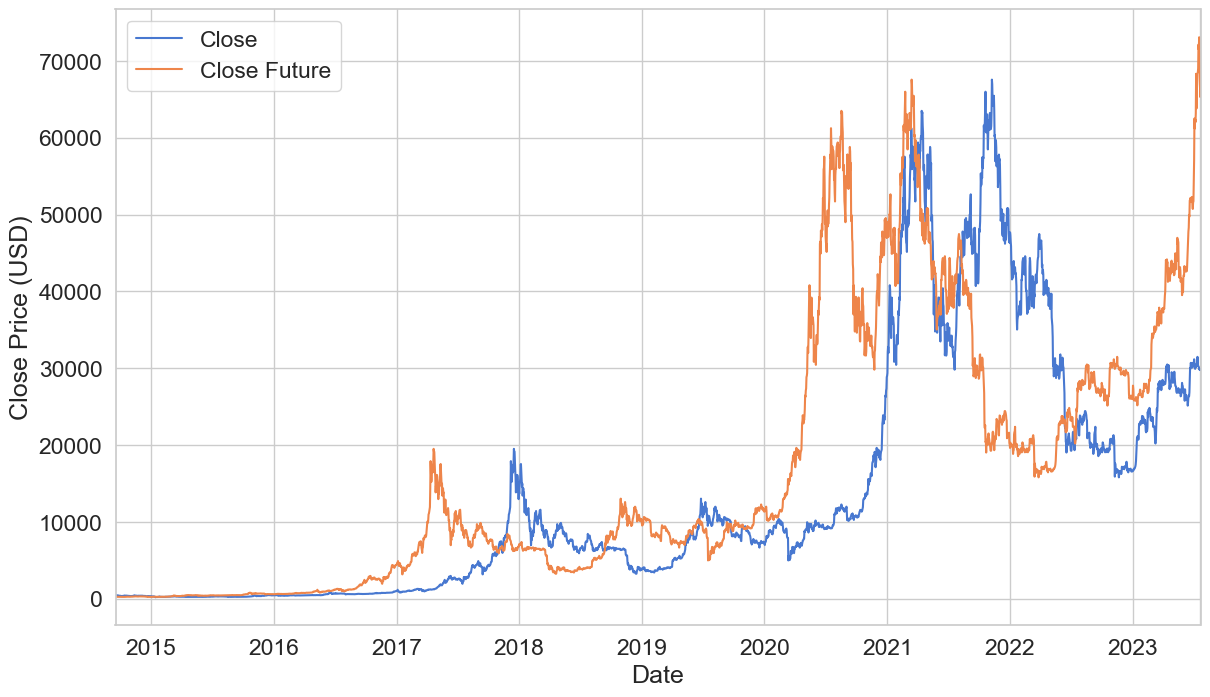

In [193]:
ax = df.plot(x='Date', y=['Close', 'Close Future']);
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [194]:
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(data)

In [195]:
data.shape

(3231, 7)

In [196]:
features = ['Close', 'Adj Close', 'Volume', 'Open', 'High', 'Low']
X_normalized = data[features]
y_normalized = data[['Close Future']]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_normalized)
y_normalized = scaler.fit_transform(y_normalized)

In [197]:
X_normalized.shape

(3231, 6)

In [198]:
y_normalized.shape

(3231, 1)

In [199]:
print(X_normalized.shape)
joblib.dump(scaler, 'scaler.gz')


(3231, 6)


['scaler.gz']

PREPROCESSING

In [200]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(X_raw, y_raw, seq_len, train_split):
    # data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])

    n_train_hours = 365 * 24
    X_train, X_test = X_raw[:num_train, :], X_raw[num_train:, :]
    y_train, y_test = y_raw[:num_train, -1], y_raw[num_train:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # X_train = data[:num_train, :-1, :]
    # y_train = data[:num_train, -1, :]

    # X_test = data[num_train:, :-1, :]
    # y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(X_normalized, y_normalized, SEQ_LEN, train_split = 0.7)

(2261, 1, 6) (2261,) (970, 1, 6) (970,)


In [201]:
y_train.shape

(2261,)

MODEL

In [202]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

d:\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [203]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=2, 
    shuffle=False
)


Epoch 1/50
71/71 - 12s - 168ms/step - loss: 0.0177 - val_loss: 0.0715
Epoch 2/50
71/71 - 2s - 25ms/step - loss: 0.0387 - val_loss: 0.0542
Epoch 3/50
71/71 - 2s - 24ms/step - loss: 0.0258 - val_loss: 0.0577
Epoch 4/50
71/71 - 2s - 28ms/step - loss: 0.0325 - val_loss: 0.0493
Epoch 5/50
71/71 - 2s - 25ms/step - loss: 0.0347 - val_loss: 0.0446
Epoch 6/50
71/71 - 3s - 39ms/step - loss: 0.0364 - val_loss: 0.0935
Epoch 7/50
71/71 - 6s - 83ms/step - loss: 0.0287 - val_loss: 0.0420
Epoch 8/50
71/71 - 5s - 71ms/step - loss: 0.0272 - val_loss: 0.0531
Epoch 9/50
71/71 - 3s - 48ms/step - loss: 0.0305 - val_loss: 0.0484
Epoch 10/50
71/71 - 4s - 52ms/step - loss: 0.0242 - val_loss: 0.0374
Epoch 11/50
71/71 - 2s - 33ms/step - loss: 0.0275 - val_loss: 0.0393
Epoch 12/50
71/71 - 3s - 38ms/step - loss: 0.0246 - val_loss: 0.0350
Epoch 13/50
71/71 - 2s - 27ms/step - loss: 0.0256 - val_loss: 0.0370
Epoch 14/50
71/71 - 2s - 23ms/step - loss: 0.0247 - val_loss: 0.0366
Epoch 15/50
71/71 - 2s - 24ms/step - loss

In [204]:
model.evaluate(X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295


0.033592578023672104

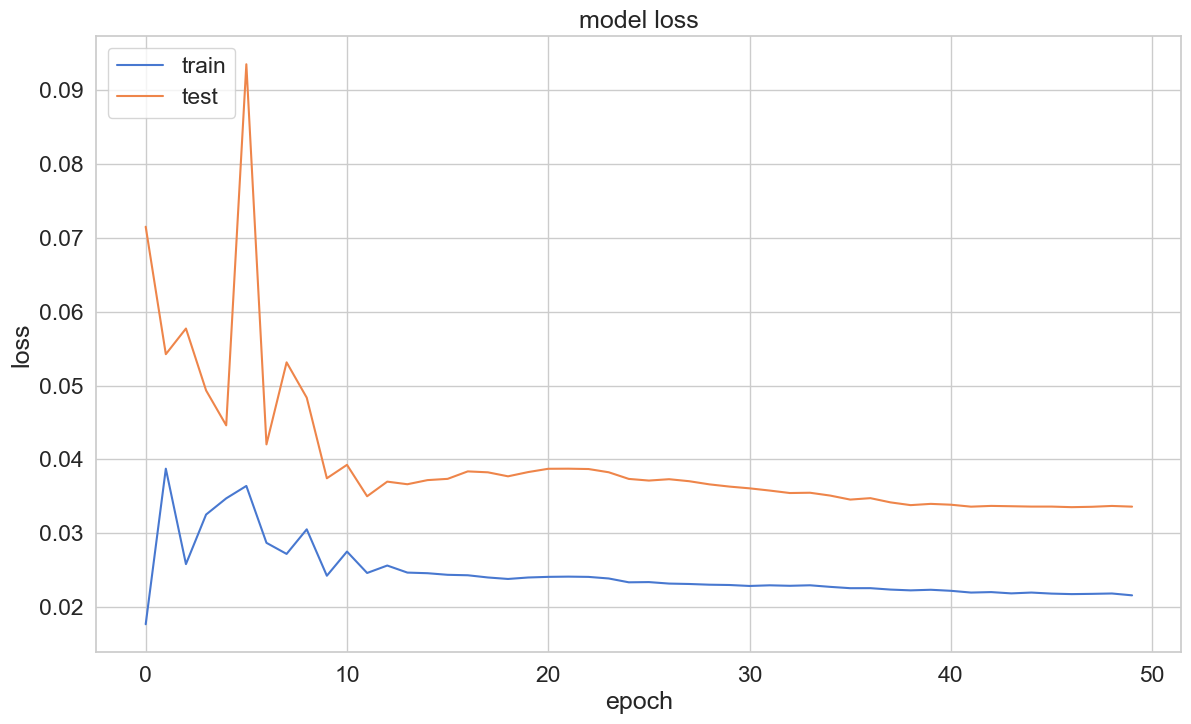

In [205]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [206]:
y_hat = model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


In [207]:
y_hat.shape

(970, 1)

In [208]:
y_test.shape

(970,)

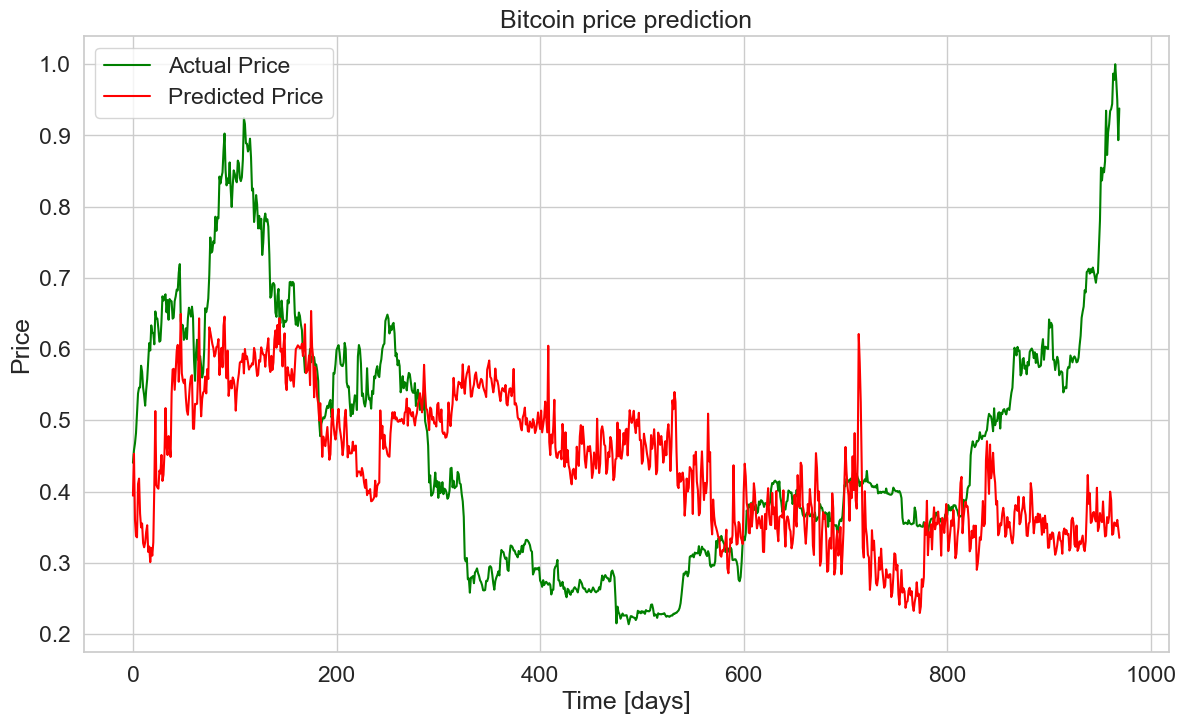

In [209]:
plt.plot(y_test, label="Actual Price", color='green')
plt.plot(y_hat, label="Predicted Price", color='red')
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

SAVE + DEPLOY

In [210]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 99, 198)        │        83,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 99, 198)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 99, 396)        │       628,848 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 99, 396)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 198)            │       392,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           199 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,317,495 (12.66 MB)

 Trainable params: 1,105,831 (4.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,211,664 (8.44 MB)

In [211]:
model.save('lstm.keras')

In [212]:
print(X_test.shape)

(970, 1, 6)


In [213]:
model.save(filepath='./1/', save_format='tf')

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

docker run -p 8501:8501 --name tfserving_classifier --mount type=bind,source=\Users\pda131212\Model\LSTM\1,target=/models/lstm -e MODEL_NAME=lstm -t tensorflow/serving